In [1]:
from io import BytesIO

import cairo
import IPython.display

from pydmap import natural_lines, hatching

In [2]:
def display_image(render_func, xsize, ysize):
    svgio = BytesIO()
    with cairo.SVGSurface(svgio, xsize, ysize) as surface:
        context = cairo.Context(surface)
        render_func(context)
    return svgio

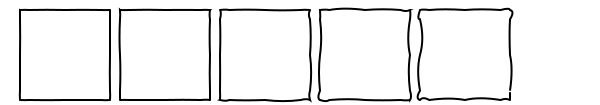

In [3]:
IPython.display.SVG(data=display_image(natural_lines.demo, 600, 105).getvalue())

122.13878543215984, 97.31333584825721 -> 117.85235783171724, 189.6245534563934
142.15958749158673, 91.22429983110864 -> 139.25155631567185, 186.24906280587928
156.45763196628798, 92.39273573950288 -> 158.82182997740946, 186.0773867902677
182.9952051344032, 91.62358211661777 -> 182.24148342295783, 188.1283074891399
201.92723363895144, 96.99428818855549 -> 201.26592214439555, 180.70245829375614


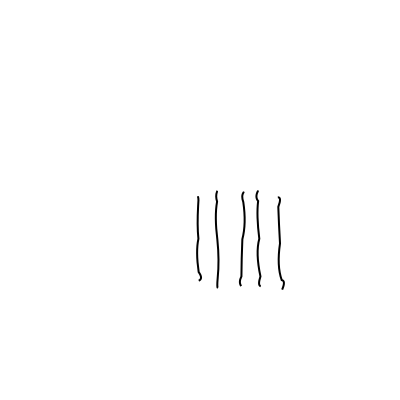

In [4]:
IPython.display.SVG(data=display_image(hatching.demo, 400, 400).getvalue())